In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.switch_backend('Agg')

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

sns.set(style='whitegrid', context='notebook')

c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Do

In [2]:
plant1_gen_path = r'C:\Users\Utilizador\Desktop\Uni\Estágios\2025 - InnoWave\Solar DG\solar_data\Plant_1_Generation_Data.csv'
plant1_weather_path = r'C:\Users\Utilizador\Desktop\Uni\Estágios\2025 - InnoWave\Solar DG\solar_data\Plant_1_Weather_Sensor_Data.csv'

plant1_gen_df = pd.read_csv(plant1_gen_path, encoding='ascii', delimiter=',')
plant1_weather_df = pd.read_csv(plant1_weather_path, encoding='ascii', delimiter=',')

print('Plant 1 Generation Data Shape:', plant1_gen_df.shape)
print('Plant 1 Weather Data Shape:', plant1_weather_df.shape)

Plant 1 Generation Data Shape: (68778, 7)
Plant 1 Weather Data Shape: (3182, 6)


In [3]:
for df in [plant1_gen_df, plant1_weather_df]:
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], errors='coerce')

print('Plant 1 Generation - Missing DATE_TIME:', plant1_gen_df['DATE_TIME'].isna().sum())
print('Plant 1 Weather - Missing DATE_TIME:', plant1_weather_df['DATE_TIME'].isna().sum())

plant1_gen_df.dropna(subset=['DATE_TIME'], inplace=True)
plant1_weather_df.dropna(subset=['DATE_TIME'], inplace=True)

Plant 1 Generation - Missing DATE_TIME: 0
Plant 1 Weather - Missing DATE_TIME: 0


Summary of Plant 1 Generation Data:
        PLANT_ID      DC_POWER      AC_POWER   DAILY_YIELD   TOTAL_YIELD
count    68778.0  68778.000000  68778.000000  68778.000000  6.877800e+04
mean   4135001.0   3147.426211    307.802752   3295.968737  6.978712e+06
std          0.0   4036.457169    394.396439   3145.178309  4.162720e+05
min    4135001.0      0.000000      0.000000      0.000000  6.183645e+06
25%    4135001.0      0.000000      0.000000      0.000000  6.512003e+06
50%    4135001.0    429.000000     41.493750   2658.714286  7.146685e+06
75%    4135001.0   6366.964286    623.618750   6274.000000  7.268706e+06
max    4135001.0  14471.125000   1410.950000   9163.000000  7.846821e+06


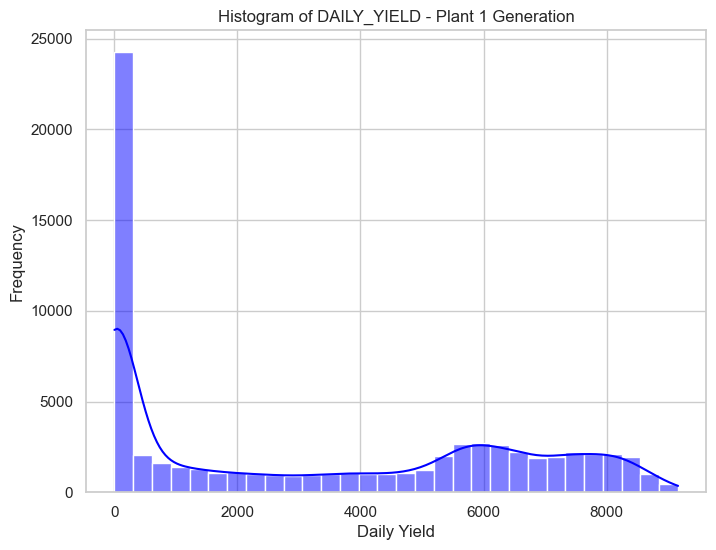

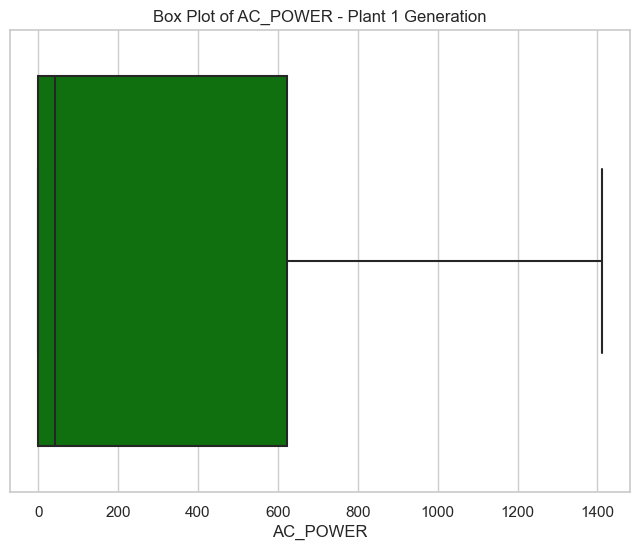

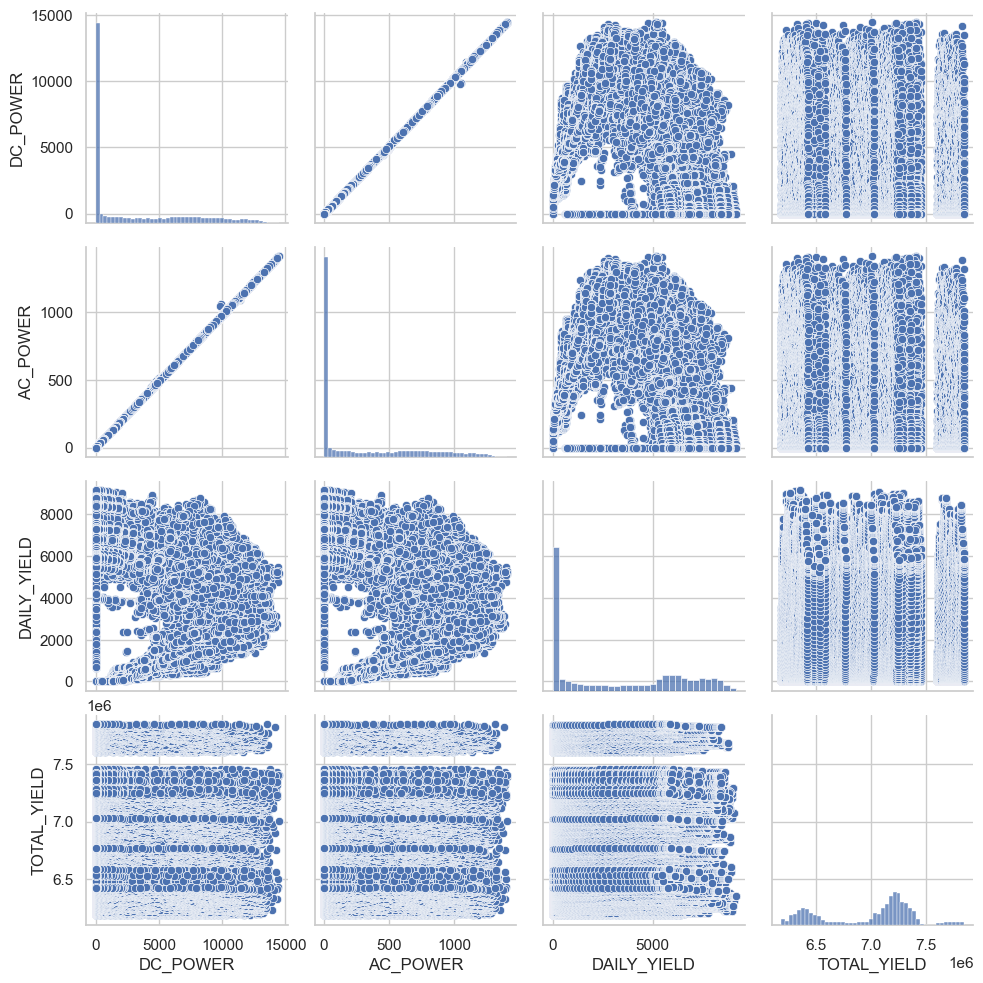

In [5]:
print('Summary of Plant 1 Generation Data:')
print(plant1_gen_df.describe())

plt.figure(figsize=(8,6))
sns.histplot(plant1_gen_df['DAILY_YIELD'], kde=True, color='blue')
plt.title('Histogram of DAILY_YIELD - Plant 1 Generation')
plt.xlabel('Daily Yield')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x=plant1_gen_df['AC_POWER'], color='green')
plt.title('Box Plot of AC_POWER - Plant 1 Generation')
plt.xlabel('AC_POWER')
plt.show()

numeric_cols = ['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
sns.pairplot(plant1_gen_df[numeric_cols])
plt.show()

Summary of Plant 1 Weather Sensor Data:
        PLANT_ID  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
count     3182.0          3182.000000         3182.000000  3182.000000
mean   4135001.0            25.531606           31.091015     0.228313
std          0.0             3.354856           12.261222     0.300836
min    4135001.0            20.398505           18.140415     0.000000
25%    4135001.0            22.705182           21.090553     0.000000
50%    4135001.0            24.613814           24.618060     0.024653
75%    4135001.0            27.920532           41.307840     0.449588
max    4135001.0            35.252486           65.545714     1.221652


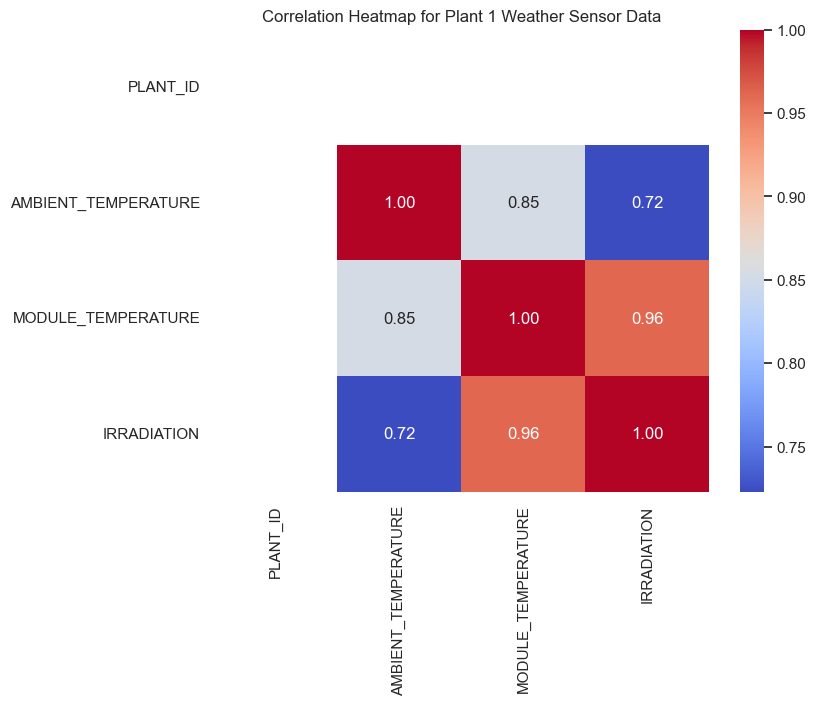

In [7]:
print('Summary of Plant 1 Weather Sensor Data:')
print(plant1_weather_df.describe())

numeric_df = plant1_weather_df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(8,6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap for Plant 1 Weather Sensor Data')
    plt.show()
else:
    print('Not enough numeric columns for a comprehensive correlation heatmap.')

In [16]:
plant1_merged = pd.merge(plant1_gen_df, plant1_weather_df, on=['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY'], how='inner')
print('Merged Plant 1 Data Shape:', plant1_merged.shape)

if plant1_merged.empty:
    print('Warning: Merged dataframe is empty. This may be due to mismatches in DATE_TIME formats or time granularity.')
    print('Please verify that the DATE_TIME columns in both datasets align properly befoe merging.')
else:
    plant1_merged.dropna(inplace=True)

    features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
    target = 'DAILY_YIELD'

    X = plant1_merged[features]
    y = plant1_merged[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    print('R2 Score for Daily Yield Prediction:', r2)

    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
    plt.xlabel('Actual Daily Yield')
    plt.ylabel('Predicted Daily Yield')
    plt.title('Actual vs Predicted Daily Yield')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
    plt.show()

Merged Plant 1 Data Shape: (0, 10)
Please verify that the DATE_TIME columns in both datasets align properly befoe merging.
